### Motivation and description

To better understand this feature, we should put ourselves in the shoes of a Scrabble player who is analyzing a game.
As a Scrabble player who wants to improve, I would like to know how various plays I am considering affect my potential win percentage.

I can examine this statically:

- For example, I am currently 10 pts ahead of my opponent, there are 30 tiles in the bag, and it is my turn. What is my current / baseline win%?

Or I can think about this with respect to various plays I am considering:

- I am 10 pts ahead of my opponent, there are 30 tiles in the bag, and I am considering two plays. If I look ahead two plies (i.e., I make a play, my opponent replies, and I draw something to my leave, and play the best static play from there), I will be X points ahead (or behind) with Y tiles in the bag, and my opponent will be on turn. What is my win % after these events?

Now, if we generate millions of games and record for every turn in every game, how many pts the _player on turn_ was ahead or behind, and how many tiles are in the bag, _prior_ to making the turn, and whether the game was won or lost for that player, we can call this dataset WP.

With WP, we can answer question 1 - we look up in WP the data point corresponding to 10 pts ahead of my opponent, with 30 tiles in the bag. I have not made my turn yet, and without knowledge of my rack, my expected win % is whatever the dataset says.

We can also answer question 2. We look up in WP the data point corresponding to X pts ahead (or behind) my opponent, with Y tiles in the bag. In this case, my opponent is on turn, so after we look up the data for this particular point (X, Y), let's call it _Ω_, we can compute 1 - _Ω_ to get the win percentage for myself.

In [18]:
# Created during May 25 HACKATHON by JD

# Calculates win percentage given on game score for both players.

In [19]:
from copy import deepcopy
import csv
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

log_files = [
    '/home/cesar/data/autogenerated-data/20220823/autogenerate_20220823_autoplay_5.csv',   # a CSW21 set
    '/home/cesar/data/autogenerated-data/20220824/autogenerate_20220825_autoplay_3.csv']   # a NWL20 set

todays_date = date.today().strftime("%Y%m%d")
pd.options.display.max_rows = 999


In [20]:
spread = {}
win_dict = {}

t0 = time.time()

# because moves are logged chronologically, we can overwrite the entry for each game ID
# for each move until we reach the final move, at which point we know the final state of the game.
for log_file in log_files:
    with open(log_file,'r') as f:
        moveReader = csv.reader(f)
        next(moveReader)

        for i,row in enumerate(moveReader):
            if (i+1)%1000000==0:
                print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

            if i<10:
                print(row)

            # This flag indicates whether p1 won or not, with 0.5 as the value if the game was tied.
            if row[0]=='p1':
                spread[row[1]] = int(row[6])-int(row[11])
            else:
                spread[row[1]] = int(row[11])-int(row[6])
            

['p1', '6305d312010f678f3a000001', '1', 'AAAEKOT', ' 8C AKATEA', '30', '30', '6', 'O', '27.504', '86', '0']
['p1', '6305d312010f678f3a000002', '1', 'CEHNOOT', ' 8C THEOCON', '82', '82', '7', '', '82.000', '86', '0']
['p2', '6305d312010f678f3a000005', '1', 'EEEIMSU', ' 8H EMEU', '12', '12', '4', 'EIS', '25.680', '86', '0']
['p2', '6305d312010f678f3a000006', '1', 'EFOORRT', ' 8D FOOTER', '26', '26', '6', 'R', '27.928', '86', '0']
['p2', '6305d312010f678f3a000002', '2', 'CDLLOTY', ' E4 CLOY.D', '24', '24', '5', 'LT', '22.888', '79', '82']
['p2', '6305d312010f678f3a000007', '1', 'EINNRRT', ' 8D TINNER', '14', '14', '6', 'R', '15.928', '86', '0']
['p1', '6305d312010f678f3a000003', '1', 'CGINOPS', ' 8D COPSING', '80', '80', '7', '', '80.000', '86', '0']
['p1', '6305d312010f678f3a000004', '1', 'ADENORR', ' 8C ADORNER', '70', '70', '7', '', '69.300', '86', '0']
['p2', '6305d312010f678f3a000001', '2', 'ACHINOZ', ' F4 HOAC.ZIN', '76', '76', '7', '', '76.000', '80', '30']
['p2', '6305d312010f678f

Processed 27000000 rows in 107.34491300582886 seconds
Processed 28000000 rows in 108.32265210151672 seconds
Processed 29000000 rows in 109.26977252960205 seconds
Processed 30000000 rows in 110.19603848457336 seconds
Processed 31000000 rows in 111.14813995361328 seconds
Processed 32000000 rows in 112.13878798484802 seconds
Processed 33000000 rows in 113.095534324646 seconds
Processed 34000000 rows in 114.05053877830505 seconds
Processed 35000000 rows in 115.02557921409607 seconds
Processed 36000000 rows in 115.9933385848999 seconds
Processed 37000000 rows in 117.06627917289734 seconds
Processed 38000000 rows in 118.02263355255127 seconds
Processed 39000000 rows in 118.95877075195312 seconds
Processed 40000000 rows in 119.89080429077148 seconds
Processed 41000000 rows in 120.82288527488708 seconds
Processed 42000000 rows in 121.7799334526062 seconds
Processed 43000000 rows in 122.71686148643494 seconds
Processed 44000000 rows in 123.66278958320618 seconds
Processed 45000000 rows in 124.6

Can define what spread beyond which you assume player has a 0 or 100% chance of winning - using 300 as first guess.

Also, spreads now range only from 0 to positive numbers, because trailing by 50 and winning is the same outcome and leading by 50 and losing (just swapping the players' perspectives)

In [21]:
for game_id in spread.keys():
    win_dict[game_id] = (np.sign(spread[game_id])+1)/2
    
# win_dict is always from the perspective of p1

In [22]:
max_spread = 300
counter_dict_by_spread_and_tiles_remaining = {x:{
    spread:0 for spread in range(max_spread,-max_spread-1,-1)} for x in range(0,94)}
win_counter_dict_by_spread_and_tiles_remaining = deepcopy(counter_dict_by_spread_and_tiles_remaining)


t0=time.time()
MAX_RACK_TILES = 7
print('There are {} games'.format(len(win_dict)))
last_evt = {}

for log_file in log_files:
    with open(log_file,'r') as f:
        moveReader = csv.reader(f)
        next(moveReader)
        
        # use this instead of DictReader because array access is much faster.
        GAME_ID = 1
        PLAYER_ID = 0
        PLAY = 4
        SCORE = 5
        TOTAL_SCORE = 6
        TILES_PLAYED = 7
        LEAVE = 8
        TILES_REMAINING = 10 
        OPP_SCORE = 11
        
        for i,row in enumerate(moveReader):
            if (i+1)%1000000==0:
                print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

            # truncate spread to the range -max_spread to max_spread
            # tiles in bag at the beginning of turn, minus tiles used, plus tiles in opponent's rack.
            if row[GAME_ID] in last_evt:
                last_row = last_evt[row[GAME_ID]]
                if int(last_row[TILES_REMAINING]) == 0:
                    # The bag might be empty. The opponent has their last leave in their rack + the number of tiles
                    # in the bag. See this sequence of moves to understand.
                    # playerID,gameID,turn,rack,play,score,totalscore,tilesplayed,leave,equity,tilesremaining,oppscore
                    # p2,6305d312010f678f3a000001,16,AEEEFSV, H1 FAVES.,39,342,5,EE,38.555,10,337
                    # p1,6305d312010f678f3a000001,17,GHMOQST,L11 MO.TH,28,365,4,GQS,17.622,5,342
                    # p2,6305d312010f678f3a000001,18,AEEILOU,K10 EUO.,22,364,3,AEIL,28.010,1,365
                    # p1,6305d312010f678f3a000001,19,AEGGIQS, M9 QIS,28,393,3,AEGG,6.000,0,364
                    # p2,6305d312010f678f3a000001,20,AEILN,15J IN.ALE,27,403,5,,39.000,0,393
                    # p2 played FAVES. keeping EE, and there were 10 tiles in the bag. So they draw 5 of them to
                    # p1 played MO.TH keeping GQS, and there were 5 tiles in the bag. So they draw 4 of them to
                    # make 7 again. 
                    # p2 played EUO. keeping AEIL, and there was 1 tile in the bag. They draw the last tile, and
                    # now have 5 in their rack.
                    # p1 played QIS keeping AEGG. There are no more tiles to draw, so they have 4 in their rack.
                    # p2 went out with IN.ALE.
                    
                    # what is the number of tiles my opponent has, before i start my turn?
                    num_tiles_in_opp_rack = min(len(last_row[LEAVE]) + int(last_row[TILES_REMAINING]), MAX_RACK_TILES)
            else:
                num_tiles_in_opp_rack = MAX_RACK_TILES
            # example of an exchange:
            # p2,6305d5d1010f678f3a064aef,17,EGOSUUU,(exch GOUUU),0,277,2,ES,11.954,14,322
            tilesplayed = int(row[TILES_PLAYED])
            if row[PLAY].startswith('(exch'):
                # Since exchanged tiles aren't played on the board, they should count as unseen
                # (back in the bag)
                tilesplayed = 0
            
            start_turn_tiles_unseen = int(row[TILES_REMAINING])+ num_tiles_in_opp_rack
            score_before_play = int(row[TOTAL_SCORE]) - int(row[SCORE])
            oppscore = int(row[OPP_SCORE])
            start_turn_spread = min(max(score_before_play - oppscore, -max_spread), max_spread)

            # we now have a start_turn_spread and a start_turn_tiles_unseen from the pov of the player whose
            # turn it currently is.
            
            
            if start_turn_tiles_unseen > 0:
                counter_dict_by_spread_and_tiles_remaining[start_turn_tiles_unseen][start_turn_spread] += 1

                # p1 is the player for whom we have calculated whether the games in win_dict are wins or losses
                if row[PLAYER_ID]=='p1':
                    win_counter_dict_by_spread_and_tiles_remaining[
                        start_turn_tiles_unseen][start_turn_spread] += (win_dict[row[GAME_ID]])
                else:
                    win_counter_dict_by_spread_and_tiles_remaining[
                        start_turn_tiles_unseen][start_turn_spread] += 1-win_dict[row[GAME_ID]]

            last_evt[row[GAME_ID]] = row
                    
            # debug rows
            if i<10:
                print(row)
                print(start_turn_spread)
                print(start_turn_tiles_unseen)
                print(counter_dict_by_spread_and_tiles_remaining[start_turn_tiles_unseen][start_turn_spread])
                print(win_counter_dict_by_spread_and_tiles_remaining[start_turn_tiles_unseen][start_turn_spread])

There are 8000000 games
['p1', '6305d312010f678f3a000001', '1', 'AAAEKOT', ' 8C AKATEA', '30', '30', '6', 'O', '27.504', '86', '0']
0
93
1
0.0
['p1', '6305d312010f678f3a000002', '1', 'CEHNOOT', ' 8C THEOCON', '82', '82', '7', '', '82.000', '86', '0']
0
93
2
1.0
['p2', '6305d312010f678f3a000005', '1', 'EEEIMSU', ' 8H EMEU', '12', '12', '4', 'EIS', '25.680', '86', '0']
0
93
3
2.0
['p2', '6305d312010f678f3a000006', '1', 'EFOORRT', ' 8D FOOTER', '26', '26', '6', 'R', '27.928', '86', '0']
0
93
4
2.0
['p2', '6305d312010f678f3a000002', '2', 'CDLLOTY', ' E4 CLOY.D', '24', '24', '5', 'LT', '22.888', '79', '82']
-82
86
1
0.0
['p2', '6305d312010f678f3a000007', '1', 'EINNRRT', ' 8D TINNER', '14', '14', '6', 'R', '15.928', '86', '0']
0
93
5
2.0
['p1', '6305d312010f678f3a000003', '1', 'CGINOPS', ' 8D COPSING', '80', '80', '7', '', '80.000', '86', '0']
0
93
6
3.0
['p1', '6305d312010f678f3a000004', '1', 'ADENORR', ' 8C ADORNER', '70', '70', '7', '', '69.300', '86', '0']
0
93
7
3.0
['p2', '6305d312010f

Processed 20000000 rows in 242.6938464641571 seconds
Processed 21000000 rows in 244.7436764240265 seconds
Processed 22000000 rows in 246.79087257385254 seconds
Processed 23000000 rows in 248.84134316444397 seconds
Processed 24000000 rows in 251.06904339790344 seconds
Processed 25000000 rows in 253.2631471157074 seconds
Processed 26000000 rows in 255.33262491226196 seconds
Processed 27000000 rows in 257.50829887390137 seconds
Processed 28000000 rows in 259.6123557090759 seconds
Processed 29000000 rows in 261.7106840610504 seconds
Processed 30000000 rows in 263.8589885234833 seconds
Processed 31000000 rows in 266.0944154262543 seconds
Processed 32000000 rows in 268.2885308265686 seconds
Processed 33000000 rows in 270.46198058128357 seconds
Processed 34000000 rows in 274.6350951194763 seconds
Processed 35000000 rows in 276.69740533828735 seconds
Processed 36000000 rows in 278.7610926628113 seconds
Processed 37000000 rows in 280.93686056137085 seconds
Processed 38000000 rows in 282.9579384

In [23]:
count_df = pd.DataFrame(counter_dict_by_spread_and_tiles_remaining)
win_df = pd.DataFrame(win_counter_dict_by_spread_and_tiles_remaining)
win_pct_df = (win_df/count_df)

def mapfn(p):
    if p == 0:
        p = 0.0001
    if p == 1:
        p = 0.9999
    return np.log(p/(1-p))

# "stretch out" the distribution by applying a logit transformation
logit_df = win_pct_df.applymap(mapfn)

Text(0.5, 1.0, 'log-odds by tiles remaining and spread')

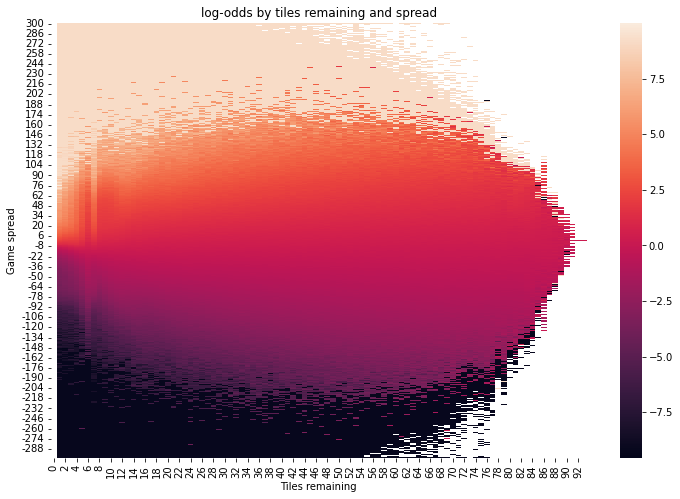

In [25]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(logit_df, ax=ax)
ax.set_xlabel('Tiles remaining')
ax.set_ylabel('Game spread')
ax.set_title('log-odds by tiles remaining and spread')

Text(0.5, 1.0, 'unsmoothed win pct by tiles remaining and spread')

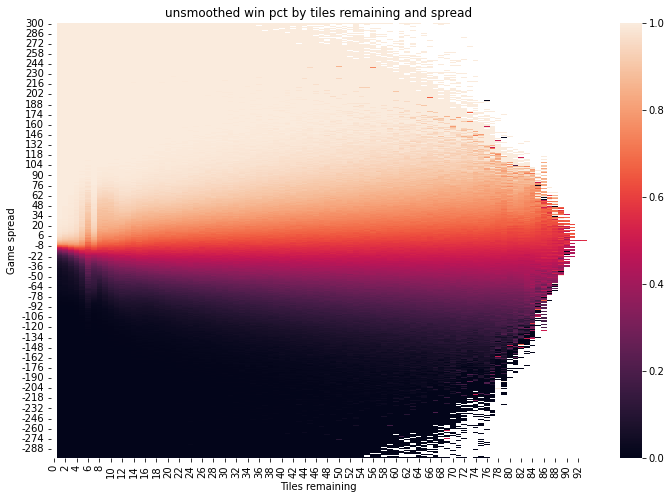

In [26]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(win_pct_df, ax=ax)
ax.set_xlabel('Tiles remaining')
ax.set_ylabel('Game spread')
ax.set_title('unsmoothed win pct by tiles remaining and spread')

In [27]:
logit_df[1][100]  # tiles remaining, 100 game spread:

9.029897050193789

#### Remove outliers by assigning to each "pixel" the average of itself and its eight neighbors, removing the highest and lowest value

In [28]:
import math
averaged_copy = logit_df.copy()

def average_around(df, i1, i2):
    s = 0
    ct = 0
    vals = []
    for x in (i1-1, i1, i1+1):
        for y in (i2-1, i2, i2+1):
#             if x == i1 and y == i2:
#                 pass
            try:
                if np.isnan(df[x][y]):
                    continue
                vals.append(df[x][y])
                s += df[x][y]
                ct += 1
            except KeyError:
                continue
    if ct > 2:  # Remove outliers from averaging.
        s -= max(vals)
        s -= min(vals)
        
        ct -= 2
    if ct == 0: return math.nan
    return s / ct


for row in logit_df.itertuples():  # one row for each spread
    spread = row.Index
    last_known_val = -100
    for idx, w in enumerate(row[1:]):  # idx here is tiles remaining
        avg = average_around(logit_df, idx, row.Index)
        if np.isnan(avg):
            if last_known_val != -100:
                averaged_copy[idx][row.Index] = last_known_val
        else:
            last_known_val = avg
            averaged_copy[idx][row.Index] = avg
        
        

Text(0.5, 1.0, 'averaged log-odds by tiles remaining and spread')

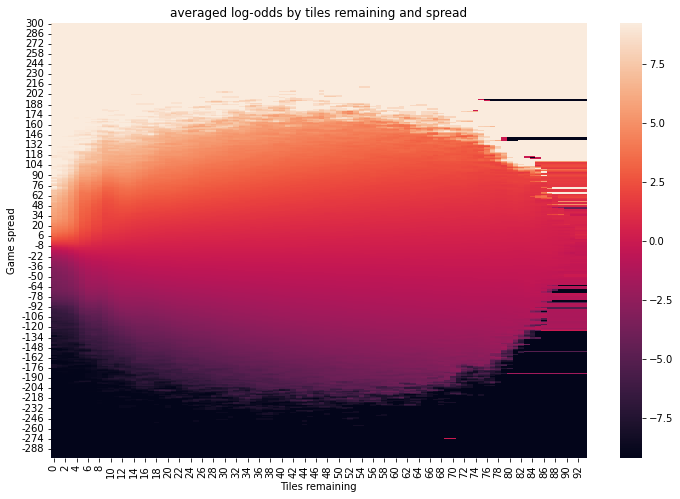

In [29]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(averaged_copy, ax=ax)
ax.set_xlabel('Tiles remaining')
ax.set_ylabel('Game spread')
ax.set_title('averaged log-odds by tiles remaining and spread')

In [30]:
def logisticfn(p):
    return np.exp(p) / (np.exp(p) + 1)

# convert back to win probability.
smoothed_winpct_df = averaged_copy.applymap(logisticfn)

Text(0.5, 1.0, 'Unsmoothed win pct by tiles remaining and spread')

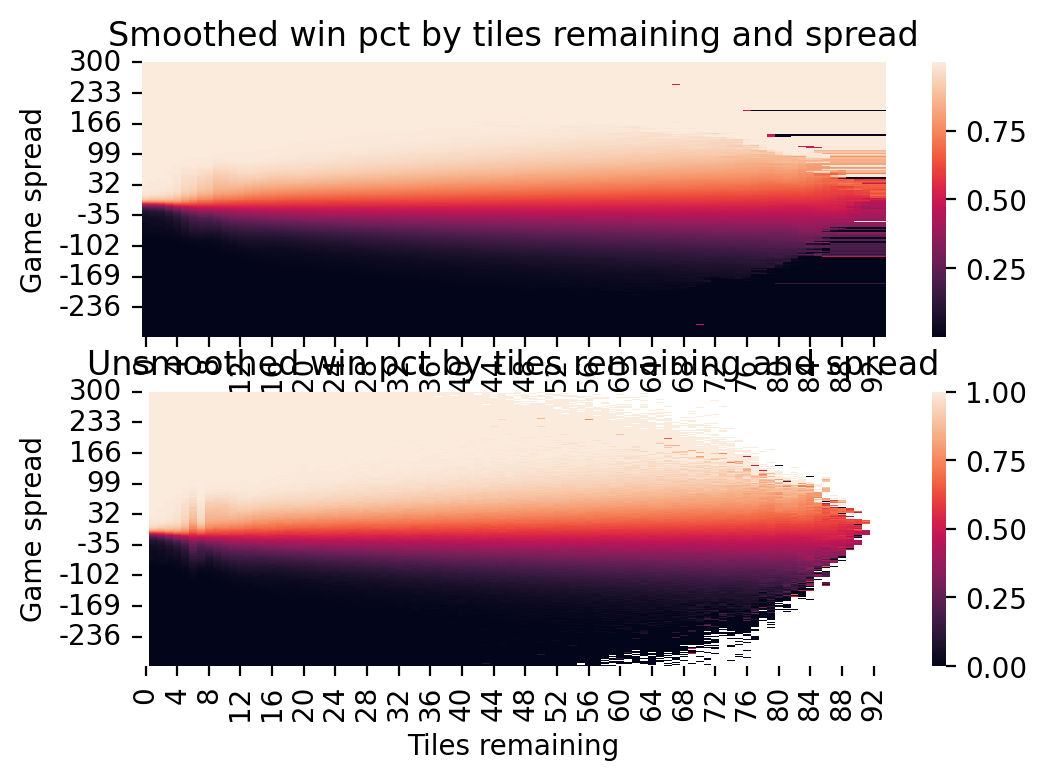

In [31]:
fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_dpi(200)
sns.heatmap(smoothed_winpct_df, ax=ax1)
ax1.set_ylabel('Game spread')
ax1.set_title('Smoothed win pct by tiles remaining and spread')

sns.heatmap(win_pct_df, ax=ax2)
ax2.set_xlabel('Tiles remaining')
ax2.set_ylabel('Game spread')
ax2.set_title('Unsmoothed win pct by tiles remaining and spread')

In [32]:
# Fill in missing data.

# Export smoothed win pct 
smoothed_winpct_df.to_csv('smoothed_winpct.csv', float_format='%.6f')

## Everything below this cell seems experimental

In [ ]:
plt.savefig('win_pct.jpg')

In [ ]:
count_df.iloc[300:350,79:]

The 50% win line is likely a little bit above 0 spread, because when you end a turn with 0 spread, your opponent on average gets an extra half-turn more than you for the rest of the game. Let's find that line.

In [ ]:
win_pct_df.iloc[250:350,79:]

## Opening turn scores

In [ ]:
pd.options.display.max_rows = 999

## Apply smoothing
We want the win percentage to increase monotonically with spread, even though we have a limited sample size and this may not always be true. Therefore, we want to be able to average win percentages over neighboring scenarios (similar spread difference and similar # of tiles remaining).

In [ ]:
counter_dict_by_opening_turn_score = {x:0 for x in range(0,131)}
win_counter_dict_by_opening_turn_score = {x:0 for x in range(0,131)}
rows = []

In [ ]:
t0=time.time()
print('There are {} games'.format(len(win_dict)))

with open(log_file,'r') as f:
    moveReader = csv.reader(f)
    next(moveReader)
    
    for i,row in enumerate(moveReader):
        if (i+1)%1000000==0:
            print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

        if row[2]=='1':
            counter_dict_by_opening_turn_score[int(row[5])] += 1
            
            # check which player went first
            if row[0]=='p1':
                win_counter_dict_by_opening_turn_score[int(row[5])] += win_dict[row[1]]
                rows.append([int(row[5]), win_dict[row[1]]])
            else:
                win_counter_dict_by_opening_turn_score[int(row[5])] += 1-win_dict[row[1]]
                rows.append([int(row[5]), 1-win_dict[row[1]]])

        
#         # debug rows
#         if i<10:
#             print(row)

In [ ]:
tst_df=pd.DataFrame(rows).rename(columns={0:'opening turn score',1:'win'})

In [ ]:
opening_turn_count = pd.Series(counter_dict_by_opening_turn_score)
opening_turn_win_count = pd.Series(win_counter_dict_by_opening_turn_score)
opening_turn_win_pct = opening_turn_win_count/opening_turn_count

In [ ]:
tst = opening_turn_win_pct.dropna()

In [ ]:
opening_turn_win_pct

In [ ]:
fig,ax=plt.subplots()
plt.plot(tst)
plt.savefig('plot1.png')

In [ ]:
fig,ax=plt.subplots()
sns.regplot(x='opening turn score',y='win',data=tst_df,x_estimator=np.mean,ax=ax)
plt.savefig('regression_plot.png')

In [ ]:
fig,ax=plt.subplots()
sns.regplot(x='opening turn score',y='win',data=tst_df,x_estimator=np.mean,ax=ax,fit_reg=False)
plt.savefig('regression_plot_no_fitline.png')